# 1 Corpus beschaffen importieren
Aufgabe 1.1  
In einem ersten Schritt wollen wir das Scraping Modul `create_record.py` importieren. Die Moduldatei hierfür sollte sich im gleichen Verzeichnis wie dieses Notebook befinden. Hiermit können wir auf die Tafsire, die auf der Seite al-tafsir.com verfügbar, zugreifen und den Text extrahieren. Damit wir die Daten, die später zu unserem Corpus werden sollen, vernünftig Zwischenspeichern können, möchten wir in einem zweiten Schritt eine leere Pandas-Serie mit dem Namen `corpus` erzeugen.

In [19]:
#import create_record#
#import pandas as pd#
##
#corpus = pd.Series({}, dtype="object")#

Da wir das Modul `create_record` noch überhaupt gar nicht kennen, schadet es nicht, einen kurzen Blick auf dessen Dokumentation zu werfen.

Aufgabe 1.2  
Rufen Sie mit Hilfe der Funktion `help()` die modulinterne Dokumentation auf und identifizieren Sie die Funktion, die uns den Text einer beliebigen Aya einer Sure aus einem beliebigen liefert!

In [21]:
#help(cr)#

Help on module create_record:

NAME
    create_record - toolset for extracting specific passages from the corpus provided on altafsir.com

FUNCTIONS
    collect_data(TafsirId, Sura, Aya)
        collects metadata and contents for given Sura and Aya from a specified Tafsir
        returns pandas.Series object with SoupContent as list of bs4.element.Tag objects
    
    get_soup(TafsirId, Sura, Aya, page=1)
        Fetch source code for any given page for TafsirID, Sura and Aya
        returns bs4.BeautifulSoup object
    
    runscript()
    
    tafsir_entry_pager(TafsirId, Sura, Aya)
        tool needed to paginate through the JavaScript generated subpages for each SearchResult for a given passage
        returns list object
    
    tafsir_getter(TafsirId, Sura, Aya, page)
        filters source code for actual tafsir content
        returns bs4.element.Tag object
    
    write_data(data, TafsirId, Sura, Aya)

FILE
    c:\users\anaconda\desktop\altafsir_scraper\create_record.py




Aufgabe 1.3a  
Nun da wir wissen, welche Funktion wir benötigen, rufen Sie diese mit den für Ihre Gruppe relevanten Parametern auf speichern Sie das Ergebnis des Funktionsaufrufes (also den arabischen Text) in der noch leeren Serie 
`corpus` unter dem key `Text` ab (Beispiel: `corpus["Schlüssel"]`)

In [20]:
#corpus["Text"] = create_record.collect_data(1,1,7)#

Sollte es Probleme beim Scrapen geben, kann alternativ die betreffende Datei geladen werden (Gruppe B: `1_1_7.txt`, Gruppe B: `1_2_7.txt`).

Aufgabe 1.3b  
Laden Sie den Text aus der für Sie relevanten Datei und speichern Sie ihn analog zu wie ihn Aufgabe 1.3 beschrieben. Beachten Sie, dass hierbei das korrekte Encoding gewählt werden muss, um eine korrekte Darstellung der arabischen Zeichen funktioniert.

In [14]:
# import pandas as pd
# with open("8_1_7_Text.txt", "r", encoding="utf-8") as f:
#     corpus["Text"] = f.read()

Nun können wir uns als erstes ein mal den Text ansehen, den wir als Ergebnis unseres Scrapingvorgangs erhalten habe:

In [27]:
corpus["Text"]

'وقوله: { صِرَاطَ الذينَ أنْعَمْتَ عَلَـيْهِمْ صِرَاطَ ٱلَّذِينَ أَنْعَمْتَ عَلَيْهِمْ غَيْرِ ٱلْمَغْضُوبِ عَلَيْهِم وَلاَ ٱلضَّآلِّينَ } إبـانة عن الصراط الـمستقـيـم أيّ الصراط هو، إذ كان كل طريق من طرق الـحقّ صراطاً مستقـيـماً، فقـيـل لـمـحمد صلى الله عليه وسلم: قل يا مـحمد: اهدنا يا ربنا الصراط الـمستقـيـم، صراط الذين أنعمت علـيهم، بطاعتك وعبـادتك من ملائكتك، وأنبـيائك، والصديقـين، والشهداء، والصالـحين. وذلك نظير ما قال ربنا جل ثناؤه فـي تنزيـله:{\xa0وَلَوْ أَنَّهُمْ فَعَلُواْ مَا يُوعَظُونَ بِهِ لَكَانَ خَيْراً لَّهُمْ وَأَشَدَّ تَثْبِيتاً * وَإِذاً لأَتَيْنَٰهُم مِّن لَّدُنَّـآ أَجْراً عَظِيماً * وَلَهَدَيْنَاهُمْ صِرَاطاً مُّسْتَقِيماً * وَمَن يُطِعِ ٱللَّهَ وَٱلرَّسُولَ فَأُوْلَـٰئِكَ مَعَ ٱلَّذِينَ أَنْعَمَ ٱللَّهُ عَلَيْهِم مِّنَ ٱلنَّبِيِّينَ وَٱلصِّدِّيقِينَ وَٱلشُّهَدَآءِ وَٱلصَّالِحِينَ\xa0} [النساء: 66-69] قال أبو جعفر: فـالذي أمر مـحمد صلى الله عليه وسلم وأمته أن يسألوه ربهم من الهداية للطريق الـمستقـيـم، هي الهداية للطريق الذي وصف الله جل ثناؤه صفته. وذلك الطريق هو طريق

____
# 2 Preprocessing
## 2.1 Normalizing data

In [16]:
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar


# def remove_citations(text):
#     import re
#     text_without_citations = re.sub("([\[\{]).*?([\]\}])", "", text)
    
#     return text_without_citations

def reduce_to_archarset(text):
    import re
    # Remove non-arabic characters
    nonarab_chars = '[^\u0621-\u064A ]'
    text = re.sub(nonarab_chars, '', text)
    return text

## normalize
def normalizer(string):
    string = normalize_unicode(string)
    string_normalized = normalize_alef_ar(string)
    string_normalized = normalize_alef_maksura_ar(string_normalized)
    string_normalized = normalize_teh_marbuta_ar(string_normalized)
    
    # remove diacritica
    string_normalized = dediac_ar(string_normalized)
    
    #reduce to arabic charset
    string_normalized = reduce_to_archarset(string_normalized)
    return string_normalized

corpus["TextNormalized"] = normalizer(corpus["Text"])

In [17]:
corpus["TextNormalized"]

' صراط الذين انعمت عليهم  بالهدايه ويبدل من الذين بصلته  غير المغضوب عليهم  وهم اليهود  ولا  وغير  الضالين  وهم النصاري ونكته البدل افاده ان المهتدين ليسوا يهودا ولا نصاريوالله اعلم بالصواب واليه المرجع والماب وصلي الله علي سيدنا محمد وعلي اله وصحبه وسلم تسليما كثيرا دائما ابدا وحسبنا الله ونعم الوكيل ولا حول ولا قوه الا بالله العلي العظيم'

## 2.2 Tokenization

### 2.2.1 Simple Tokenization
Will tokenize words by splitting the string on whitespace and punctuation.

In [8]:
from camel_tools.tokenizers.word import simple_word_tokenize

corpus["Tokenized"] = simple_word_tokenize(corpus["TextNormalized"])

### 2.2.2 Morphological tokenization
The morphological tokenizer expects pre-tokenized text in a list. Therefore run simple_word_tokenize(string) first

In [9]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer


# Load a pretrained disambiguator to use with a tokenizer
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# `split=True`: morphological tokens are output as seperate strings.
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok', split=True)
corpus["TokenizedMorph"] = tokenizer.tokenize(corpus["Tokenized"])

# Rausfiltern unselbständiger Morpheme
corpus["TokenizedMorph"] = [token for token in corpus["TokenizedMorph"] if not '+' in token]

In [10]:
corpus["TokenizedMorph"]

['يقول',
 'تعالى',
 'ذكر',
 'أنا',
 'أعطينا',
 'يا',
 'محمد',
 'كوثر',
 'أختلف',
 'أهل',
 'تأويل',
 'في',
 'معنى',
 'كوثر',
 'قال',
 'عض',
 'هو',
 'نهر',
 'في',
 'جنة',
 'أعطى',
 'الله',
 'نبيه',
 'محمدا',
 'صلى',
 'الله',
 'على',
 'سلم',
 'حدث',
 'يعقوب',
 'قال',
 'ثنا',
 'هشيم',
 'قال',
 'أخبر',
 'عطاء',
 'بن',
 'سائب',
 'عن',
 'محارب',
 'بن',
 'دثار',
 'عن',
 'ابن',
 'عمر',
 'أن',
 'قال',
 'كوثر',
 'نهر',
 'في',
 'جنة',
 'حافتا',
 'من',
 'ذهب',
 'فضة',
 'يجري',
 'على',
 'در',
 'ياقوت',
 'ماء',
 'أشد',
 'بياضا',
 'من',
 'لبن',
 'أحلى',
 'من',
 'عسل',
 'حدث',
 'ابن',
 'حميد',
 'قال',
 'ثنا',
 'جرير',
 'عن',
 'عطاء',
 'عن',
 'محارب',
 'بن',
 'دثار',
 'الباهلي',
 'عن',
 'ابن',
 'عمر',
 'في',
 'قول',
 'أنا',
 'أعطينا',
 'كوثر',
 'قال',
 'نهر',
 'في',
 'جنة',
 'حافتا',
 'ذهب',
 'مجرى',
 'على',
 'در',
 'ياقوت',
 'ماء',
 'أشد',
 'بياضا',
 'من',
 'ثلج',
 'أشد',
 'حلاوة',
 'من',
 'عسل',
 'تربة',
 'أطيب',
 'من',
 'ريح',
 'ألمس',
 'حدث',
 'أبو',
 'ريب',
 'قال',
 'ثنا',
 'عمر',
 'بن',
 'عبيد',
 

## [2.3 Remove stopwords from token list]
normalization needs to implemented for stoplist, before usable

In [19]:
def stopwords(token_list, stopwords_list, morph=True):

    token_list_filtered = []
    words_removed = []
    with open (stopwords_list, encoding="UTF-8") as stopwords:
        if morph == True:
            x = stopwords.read()
        else:
            x = normalizer(stopwords.read())
        for token in token_list:
            if token not in x:
                token_list_filtered.append(token)
            if token in x:
                words_removed.append(token)

    return token_list_filtered, words_removed

In [20]:
corpus["TokenizedMorphStopword"] = stopwords(corpus["TokenizedMorph"], 'C:/Users/anaconda/Desktop/arabic-stop-words-master/list2.txt')[0]
corpus["TokenizedStopword"] = stopwords(corpus["Tokenized"], 'C:/Users/anaconda/Desktop/arabic-stop-words-master/list2.txt', morph=False)[0]


----
# 3 Analyzing data
## 3.1 Morphological analysis of tokens

In [11]:
import pandas as pd
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer


# set up morphological analyzer
db = MorphologyDB.builtin_db("calima-msa-r13")
analyzer = Analyzer(db)

# create dictionary for every token taking index value in corpus["tokenized"] as key
corpus_token_analysis = {}
for i, val in enumerate(corpus["Tokenized"]):
    corpus_token_analysis[i] = pd.DataFrame(analyzer.analyze(corpus["Tokenized"][i]))


In [15]:
corpus_token_analysis[34]

,diac,lex,bw,gloss,pos,prc3,prc2,prc1,prc0,per,...,root,bwtok,pattern,lex_logprob,atbtok,atbseg,d1seg,stem,stemgloss,stemcat
0,أَخْبَرْنا,أَخْبَر,أَخْبَر/PV+نا/PVSUFF_SUBJ:1P,notify;communicate+we_<verb>,verb,0,0,0,0,1,...,خ.ب.ر,أَخْبَر_+نا,أَ1ْ2َ3ْنا,-5.099521,أَخْبَرْنا,أَخْبَرْنا,أَخْبَرْنا,أَخْبَر,notify;communicate,PV
1,أَخْبَرَنا,أَخْبَر,أَخْبَر/PV+َ/PVSUFF_SUBJ:3MS+نا/PVSUFF_DO:1P,notify;communicate+he;it_<verb>_us,verb,0,0,0,0,3,...,خ.ب.ر,أَخْبَر_+َ_+نا,أَ1ْ2َ3َنا,-5.099521,أَخْبَرَ_+نا,أَخْبَرَ_+نا,أَخْبَرَنا,أَخْبَر,notify;communicate,PV


## 3.2 Frequency analysis

In [98]:
# create with root as key and frequency count as val
freqs = {}
def frequency_analyzer(token_list):
    token_freqs = {}
    for token in token_list:
        if token in token_freqs:
            token_freqs[token] += 1
        else:
            token_freqs[token] = 1

    # sorting
    token_freqs = {k: v for k, v in sorted(token_freqs.items(), key=lambda item: item[1], reverse=True)}
    return token_freqs

### 3.2.1 ... of morphologically tokenized tokens

In [99]:
freqs["TokenizedMorphStopword"]= frequency_analyzer(corpus["TokenizedMorphStopword"])

### 3.2.2 ... of roots

In [100]:
# create list of roots for the lemma with max probability for a given token from tokens_analysis
corpus["RootsList"] = []
for i in range(1, len(corpus["Tokenized"])):
    if "lex_logprob" in corpus_token_analysis[i]:
        corpus["RootsList"].append(corpus_token_analysis[i][corpus_token_analysis[i].lex_logprob == corpus_token_analysis[i].lex_logprob.max()].iloc[0]["root"])


In [101]:
freqs["RootsList"] = frequency_analyzer(corpus["RootsList"])

---
# --- Transliteration --- #

In [60]:
from camel_tools.utils.charmap import CharMapper
from camel_tools.utils.transliterate import Transliterator



# Instantiate the builtin bw2ar (Buckwalter to Arabic) CharMapper
ar2bw = CharMapper.builtin_mapper('ar2bw')

# Instantiate Transliterator with the bw2ar CharMapper with '@@IGNORE@@' marker (default)
ar2bw_translit = Transliterator(ar2bw)

# Generate Arabic transliteration from BW




corpus["RootsListTransliterated"] = []
for i in corpus["RootsList"]:
    corpus["RootsListTransliterated"].append(ar2bw_translit.transliterate(i))


corpus["TokenizedMorphTransliterated"] = []
for i in corpus["TokenizedMorph"]:
    corpus["TokenizedMorphTransliterated"].append(ar2bw_translit.transliterate(i))

-----

## 3.3 Named-entity recognition
Hint: it seems that simple tokenization is more apt for NER, as it doesn't remove enclitics like "ك" from parts of the name

In [25]:
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.ner import NERecognizer

ner = NERecognizer.pretrained()

# NERecognizer expects pre-tokenized text
sentence = t1s114a1["Tokenized"] # simple_word_tokenize(t1s114a1["Text"])

labels = ner.predict_sentence(sentence)

# save each token paired with it's NER label
zipped = list(zip(sentence, labels))


In [29]:
# Filter and glue named entities into dictionary
named_entities = {"LOC" : [], "ORG" : [], "PERS" : [], "MISC" : []}
for i, val in enumerate(zipped):
    if zipped[i][1][0] == "B":
        named_entities[zipped[i][1][2:]].append(zipped[i][0])
    if zipped[i][1][0] == "I":
        named_entities[zipped[i][1][2:]][-1] = named_entities[zipped[i][1][2:]][-1] + " " + zipped[i][0]
named_entities["MISC"]

['الله',
 'الله',
 'الكوثر',
 'الكوثر',
 'الياقوت',
 'اللؤلؤ',
 'الكوثر',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الكوثر',
 'الله',
 'الله',
 'الكوثر',
 'الله',
 'الله',
 'الله',
 'الكوثر',
 'الله',
 'الله',
 'الكوثر',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الياقوت',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'اللؤلؤ',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الكوثر',
 'الله',
 'الله',
 'الله',
 'الله',
 'الكوثر',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الياقوت',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الله',
 'الكوثر',
 'الله',
 'الله',
 'الله',
 'الله',
 'الفجر',
 'الله',
 'الله',
 'الله',
 'لله',
 'بالله',
 'الله',
 'الله',
 'الحديبيه',
 'الله',
 'البيت',
 'الله',
 'الله',
 'الله',
 'ربك',
 'الله',
 'الله',
 'الكوثر',
 'الابتر',
 'ال

# 4 Visualization

## 4.1 Barplot of Root frequencies

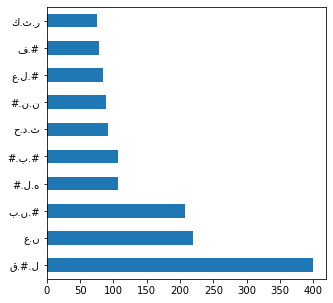

In [105]:
freq = pd.Series(frequency_analyzer(corpus["RootsList"]))[:20]

import matplotlib.pyplot as plt

freq.plot(kind="barh", figsize=(5, 5))
plt.show()

## 4.2 Wordcloud of most frequent words

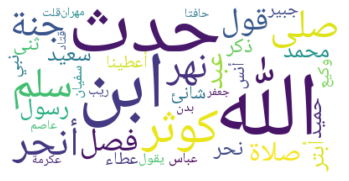

In [116]:
from collections import Counter

from wordcloud import WordCloud          # pip install wordcloud
import matplotlib.pyplot as plt          
# -- Arabic text dependencies
from arabic_reshaper import reshape      # pip install arabic-reshaper
from bidi.algorithm import get_display   # pip install python-bidi

rtl = lambda w: get_display(reshape(f'{w}'))

COUNTS = Counter(corpus["TokenizedMorphStopword"])
counts = {rtl(k):v for k, v in COUNTS.most_common(40)}



font_file = './NotoNaskhArabic-Regular.ttf'
wordcloud = WordCloud(font_path=font_file, background_color="white").generate_from_frequencies(counts)
wordcloud.to_file("wordcloud_example.png")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
